# Phase 1: Data Collection & Audit

This notebook fetches Google Trends data and validates data quality.

**Important Note on Google Trends Resolution:**
- **Long date ranges** (2004-present) → Returns **monthly** frequency
- **Medium date ranges** (e.g., 1-3 years) → Returns **weekly** frequency
- **Short date ranges** (≤270 days) → Returns **daily** frequency

**Objectives:**
1. Load configuration from config.yaml
2. Fetch historical monthly data (2004-present) for context
3. Fetch weekly data for the specified date range (ground truth)
4. Calculate optimal daily chunk allocation
5. Fetch all daily chunks (≤266 days each) with progress tracking
6. Validate data quality and generate audit report
7. Save all data to parquet files

**Outputs:**
- `data/raw/historical_monthly.parquet`
- `data/raw/weekly.parquet`
- `data/raw/daily_chunks/chunk_00.parquet` ... `chunk_N.parquet`
- `reports/stage0_audit.txt`

## 1. Setup and Imports

In [11]:
import sys
from pathlib import Path

# Add src to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root / "src"))

In [12]:
import warnings
from utils import FileManager, setup_logger, calculate_chunk_parameters
from validation import DataValidator, ValidationReport
from api import TrendsAPI
from config import ConfigManager
from tqdm.auto import tqdm
import numpy as np
import pandas as pd

# Suppress warnings
warnings.filterwarnings('ignore')

print("✓ Imports successful")

✓ Imports successful


## 2. Load Configuration

In [3]:
# Initialize file manager
file_manager = FileManager(base_dir=project_root)
file_manager.ensure_directories()

# Setup logging
log_path = file_manager.get_log_path("01_data_collection.log")
logger = setup_logger(log_file=log_path, level="DEBUG", console_level="INFO")

# Load configuration
config_path = project_root / "config.yaml"
config = ConfigManager(config_path=config_path)

print(config.summary())

2025-11-11 15:54:34.805 | INFO     | utils:ensure_directories:50 - Ensured all directories exist under /home/mikhailarutyunov/projects/google-trends-daily-data-preprocessing
2025-11-11 15:54:34 | INFO     | Logging to file: /home/mikhailarutyunov/projects/google-trends-daily-data-preprocessing/logs/01_data_collection.log
2025-11-11 15:54:34 | WARNING  | Environment file not found: .env
2025-11-11 15:54:34 | INFO     | Loaded configuration from /home/mikhailarutyunov/projects/google-trends-daily-data-preprocessing/config.yaml
2025-11-11 15:54:34 | SUCCESS  | Configuration validated successfully


Configuration Summary
Search Term: flu vaccine
Date Range: 2022-01-01 to 2024-12-31 (1096 days)
Overlap: 60 days
Random Seed: 42

Stitching Weights:
  Monthly: 1.0
  Weekly: 0.5
  Overlap: 0.1

Zero Handling:
  Threshold: 0.01
  Structural Zero Months: [6, 7, 8]

Optimization:
  Max Iterations: 1000
  Tolerance: 1e-08

SerpAPI:
  Timeout: 90s
  Max Retries: 5
  Retry Delay: 2s


## 3. Initialize API Client

In [4]:
# Get SerpAPI key from environment
serpapi_key = config.get_api_key("SERPAPI_KEY")

api = TrendsAPI(
    api_key=serpapi_key,
    timeout=config.serpapi.timeout,  # Should be 90 now
    max_retries=config.serpapi.max_retries,  # Should be 5 now
    retry_delay=config.serpapi.retry_delay,
)

print("✓ TrendsAPI re-initialized")
print(f"  Timeout: {api.timeout}s")
print(f"  Max retries: {api.max_retries}")

2025-11-11 15:54:37 | INFO     | TrendsAPI initialized


✓ TrendsAPI re-initialized
  Timeout: 90s
  Max retries: 5


## 4. Fetch Historical Monthly Data (2004-present)

For long date ranges, Google Trends returns **monthly** frequency data.

In [19]:
print(f"Fetching historical monthly data for '{config.search_term}' (2004-present)...")

historical_monthly_data = api.fetch_historical_monthly(
    search_term=config.search_term,
    start_year=2004,  # Google Trends starts from 2004
)

# Save to parquet
historical_path = file_manager.get_raw_data_path("historical_monthly")
historical_monthly_data.to_parquet(historical_path, index=False)

print(f"✓ Fetched {len(historical_monthly_data)} monthly data points")
print(f"✓ Saved to {historical_path}")

# Display sample
historical_monthly_data.head()

2025-11-11 21:18:52 | INFO     | Fetching data for 'flu vaccine' (2004-01-01 to 2025-12-31)


Fetching historical monthly data for 'flu vaccine' (2004-present)...


2025-11-11 21:20:23 | WARNING  | Request timeout. Retrying in 2s (attempt 1/5)
2025-11-11 21:20:25 | SUCCESS  | Fetched 263 data points for 'flu vaccine' (2004-01-01 to 2025-12-31)


✓ Fetched 263 monthly data points
✓ Saved to /home/mikhailarutyunov/projects/google-trends-daily-data-preprocessing/data/raw/historical_monthly.parquet


,date,value,is_partial
0,2004-01-01,2,False
1,2004-02-01,2,False
2,2004-03-01,1,False
3,2004-04-01,1,False
4,2004-05-01,0,False


## 5. Fetch Weekly Data for Date Range

For the specified date range (typically 1-3 years), Google Trends returns **weekly** frequency data.  
This serves as ground truth for validation.

In [6]:
print(f"Fetching weekly data for '{config.search_term}'...")

weekly_data = api.fetch_weekly(
    search_term=config.search_term,
    start_date=config.date_range.start,
    end_date=config.date_range.end,
)

# Save to parquet
weekly_path = file_manager.get_raw_data_path("weekly")
weekly_data.to_parquet(weekly_path, index=False)

print(f"✓ Fetched {len(weekly_data)} weekly data points")
print(f"✓ Saved to {weekly_path}")

# Display sample
weekly_data.head()

2025-11-11 15:54:42 | INFO     | Fetching data for 'flu vaccine' (2022-01-01 to 2024-12-31)
2025-11-11 15:54:42 | SUCCESS  | Fetched 158 data points for 'flu vaccine' (2022-01-01 to 2024-12-31)


Fetching weekly data for 'flu vaccine'...
✓ Fetched 158 weekly data points
✓ Saved to /home/mikhailarutyunov/projects/google-trends-daily-data-preprocessing/data/raw/weekly.parquet


,date,value,is_partial
0,2021-12-26,46,False
1,2022-01-02,53,False
2,2022-01-09,44,False
3,2022-01-16,31,False
4,2022-01-23,25,False


## 6. Calculate Daily Chunk Parameters

In [7]:
total_days = config.date_range.total_days
overlap_days = config.daily.overlap_days

num_chunks, chunk_ranges = calculate_chunk_parameters(
    total_days=total_days,
    max_chunk_size=266,  # Google Trends limit for daily data
    overlap_days=overlap_days,
)

print(f"\nChunking Strategy:")
print(f"  Total days: {total_days}")
print(f"  Overlap: {overlap_days} days")
print(f"  Number of chunks: {num_chunks}")
print(f"  Chunk size: 266 days (max)")
print(f"  Effective increment: {266 - overlap_days} days")

2025-11-11 15:54:44 | INFO     | Calculated 6 chunks for 1096 days (chunk_size=266, overlap=60)



Chunking Strategy:
  Total days: 1096
  Overlap: 60 days
  Number of chunks: 6
  Chunk size: 266 days (max)
  Effective increment: 206 days


## 7. Fetch Daily Chunks

For short date ranges (≤266 days), Google Trends returns **daily** frequency data.

In [15]:
print(f"\nFetching {num_chunks} daily chunks with progress tracking...\n")

# Add error handling and partial save
daily_chunks = []
failed_chunks = []

for i in range(num_chunks):
    try:
        # Calculate chunk dates
        effective_chunk_size = 266 - overlap_days
        start_offset = i * effective_chunk_size

        chunk_start = pd.to_datetime(config.date_range.start) + pd.Timedelta(days=start_offset)
        chunk_end = min(
            chunk_start + pd.Timedelta(days=265),
            pd.to_datetime(config.date_range.end)
        )

        chunk_start_str = chunk_start.strftime("%Y-%m-%d")
        chunk_end_str = chunk_end.strftime("%Y-%m-%d")

        print(f"Fetching chunk {i}/{num_chunks}: {chunk_start_str} to {chunk_end_str}")

        chunk_df = api.fetch_daily(config.search_term, chunk_start_str, chunk_end_str)
        daily_chunks.append(chunk_df)

        # Save immediately after successful fetch
        chunk_path = file_manager.get_daily_chunk_path(i)
        chunk_df.to_parquet(chunk_path, index=False)
        print(f"✓ Saved chunk {i}: {len(chunk_df)} rows\n")

        # Rate limiting delay
        if i < num_chunks - 1:
            import time
            print(f"Waiting 10s before next request...")
            time.sleep(10)

    except Exception as e:
        print(f"✗ Failed to fetch chunk {i}: {e}")
        failed_chunks.append(i)
        # Add empty DataFrame as placeholder to maintain chunk numbering
        daily_chunks.append(pd.DataFrame(columns=['date', 'value', 'is_partial']))
        continue

print(f"\n{'=' * 60}")
print(f"Fetch Summary:")
print(f"  Successfully fetched: {num_chunks - len(failed_chunks)}/{num_chunks} chunks")
print(f"  Total daily data points: {sum(len(chunk) for chunk in daily_chunks)}")
if failed_chunks:
    print(f"  ⚠ Failed chunks: {failed_chunks}")
    print(f"  Tip: Re-run this cell to retry failed chunks")
else:
    print(f"  ✓ All chunks fetched successfully!")
print(f"{'=' * 60}\n")

2025-11-11 16:55:05 | INFO     | Fetching data for 'flu vaccine' (2022-01-01 to 2022-09-23)



Fetching 6 daily chunks with progress tracking...

Fetching chunk 0/6: 2022-01-01 to 2022-09-23


2025-11-11 16:56:35 | WARNING  | Request timeout. Retrying in 2s (attempt 1/5)
2025-11-11 16:58:07 | WARNING  | Request timeout. Retrying in 4s (attempt 2/5)
2025-11-11 16:59:28 | SUCCESS  | Fetched 266 data points for 'flu vaccine' (2022-01-01 to 2022-09-23)


✓ Saved chunk 0: 266 rows

Waiting 10s before next request...


2025-11-11 16:59:38 | INFO     | Fetching data for 'flu vaccine' (2022-07-26 to 2023-04-17)


Fetching chunk 1/6: 2022-07-26 to 2023-04-17


2025-11-11 17:00:11 | SUCCESS  | Fetched 266 data points for 'flu vaccine' (2022-07-26 to 2023-04-17)


✓ Saved chunk 1: 266 rows

Waiting 10s before next request...


2025-11-11 17:00:21 | INFO     | Fetching data for 'flu vaccine' (2023-02-17 to 2023-11-09)


Fetching chunk 2/6: 2023-02-17 to 2023-11-09


2025-11-11 17:01:51 | WARNING  | Request timeout. Retrying in 2s (attempt 1/5)
2025-11-11 17:01:53 | SUCCESS  | Fetched 266 data points for 'flu vaccine' (2023-02-17 to 2023-11-09)


✓ Saved chunk 2: 266 rows

Waiting 10s before next request...


2025-11-11 17:02:03 | INFO     | Fetching data for 'flu vaccine' (2023-09-11 to 2024-06-02)
2025-11-11 17:02:03 | SUCCESS  | Fetched 266 data points for 'flu vaccine' (2023-09-11 to 2024-06-02)


Fetching chunk 3/6: 2023-09-11 to 2024-06-02
✓ Saved chunk 3: 266 rows

Waiting 10s before next request...


2025-11-11 17:02:13 | INFO     | Fetching data for 'flu vaccine' (2024-04-04 to 2024-12-25)
2025-11-11 17:02:13 | SUCCESS  | Fetched 266 data points for 'flu vaccine' (2024-04-04 to 2024-12-25)


Fetching chunk 4/6: 2024-04-04 to 2024-12-25
✓ Saved chunk 4: 266 rows

Waiting 10s before next request...


2025-11-11 17:02:23 | INFO     | Fetching data for 'flu vaccine' (2024-10-27 to 2024-12-31)


Fetching chunk 5/6: 2024-10-27 to 2024-12-31


2025-11-11 17:03:54 | WARNING  | Request timeout. Retrying in 2s (attempt 1/5)
2025-11-11 17:05:26 | WARNING  | Request timeout. Retrying in 4s (attempt 2/5)
2025-11-11 17:07:00 | WARNING  | Request timeout. Retrying in 8s (attempt 3/5)
2025-11-11 17:08:38 | WARNING  | Request timeout. Retrying in 16s (attempt 4/5)
2025-11-11 17:09:48 | SUCCESS  | Fetched 66 data points for 'flu vaccine' (2024-10-27 to 2024-12-31)


✓ Saved chunk 5: 66 rows


Fetch Summary:
  Successfully fetched: 6/6 chunks
  Total daily data points: 1396
  ✓ All chunks fetched successfully!



## 8. Data Validation and Audit

In [20]:
print("\nRunning data validation...\n")

# Check if we have daily chunks
if 'daily_chunks' not in locals() or not daily_chunks:
    print("⚠ No daily chunks available. Skipping daily chunk validation.")
    valid_daily_chunks = None
else:
    # Filter out empty placeholder chunks
    valid_daily_chunks = [chunk for chunk in daily_chunks if len(chunk) > 0]
    print(f"Validating {len(valid_daily_chunks)}/{len(daily_chunks)} non-empty chunks")

# Initialize validator
validator = DataValidator(zero_threshold=config.stitching.zero_threshold)

# Run validation
validation_report = validator.validate(
    monthly=weekly_data,  # Using weekly as primary ground truth
    weekly=None,
    daily_chunks=valid_daily_chunks,
    structural_zero_months=config.stitching.structural_zero_months,
)

# Display report
print(validation_report.summary())

2025-11-11 21:20:35 | INFO     | Starting validation...
2025-11-11 21:20:35 | INFO     | Validating monthly data...
2025-11-11 21:20:35 | INFO     | monthly: 0 structural zeros, 0 sampling zeros
2025-11-11 21:20:35 | INFO     | Validating 6 daily chunks...
2025-11-11 21:20:35 | INFO     | Validating 6 daily chunks...
2025-11-11 21:20:35 | INFO     | Checking overlaps between consecutive chunks...
2025-11-11 21:20:35 | INFO     | Chunk 0-1 overlap: 60 days
2025-11-11 21:20:35 | INFO     | Chunk 1-2 overlap: 60 days
2025-11-11 21:20:35 | INFO     | Chunk 2-3 overlap: 60 days
2025-11-11 21:20:35 | INFO     | Chunk 3-4 overlap: 60 days
2025-11-11 21:20:35 | INFO     | Chunk 4-5 overlap: 60 days
2025-11-11 21:20:35 | INFO     | Daily chunk validation complete
2025-11-11 21:20:35 | INFO     | Calculating statistics...
2025-11-11 21:20:35 | INFO     | Validation complete: VALID



Running data validation...

Validating 6/6 non-empty chunks

Validation Report - Status: VALID

STATISTICS:
  monthly_zero_count: 0
  monthly_zero_percentage: 0.0%
  monthly_structural_zeros: 0
  monthly_sampling_zeros: 0
  chunk_0_1_overlap_days: 60
  chunk_1_2_overlap_days: 60
  chunk_2_3_overlap_days: 60
  chunk_3_4_overlap_days: 60
  chunk_4_5_overlap_days: 60
  monthly_count: 158
  monthly_mean: 28.37
  monthly_std: 25.04
  monthly_min: 6
  monthly_max: 100
  num_daily_chunks: 6
  total_daily_points: 1396



## 9. Save Audit Report

In [17]:
# Save audit report to file
audit_path = file_manager.get_report_path("stage0_audit.txt")

with open(audit_path, "w") as f:
    f.write("Google Trends Data Collection - Stage 0 Audit Report\n")
    f.write("=" * 70 + "\n\n")
    f.write(config.summary())
    f.write("\n\n")
    f.write("Data Collection Summary:\n")
    f.write(f"  Historical Monthly: {len(historical_monthly_data)} points (2004-present)\n")
    f.write(f"  Weekly: {len(weekly_data)} points ({config.date_range.start} to {config.date_range.end})\n")
    f.write(f"  Daily Chunks: {len(daily_chunks)} chunks\n")
    f.write(f"  Total Daily Points: {sum(len(chunk) for chunk in daily_chunks)}\n")
    f.write("\n\n")
    f.write(validation_report.summary())

print(f"\n✓ Audit report saved to {audit_path}")


✓ Audit report saved to /home/mikhailarutyunov/projects/google-trends-daily-data-preprocessing/reports/stage0_audit.txt


## 10. Visual Inspection

✓ Plot saved to /home/mikhailarutyunov/projects/google-trends-daily-data-preprocessing/reports/stage0_data_overview.png


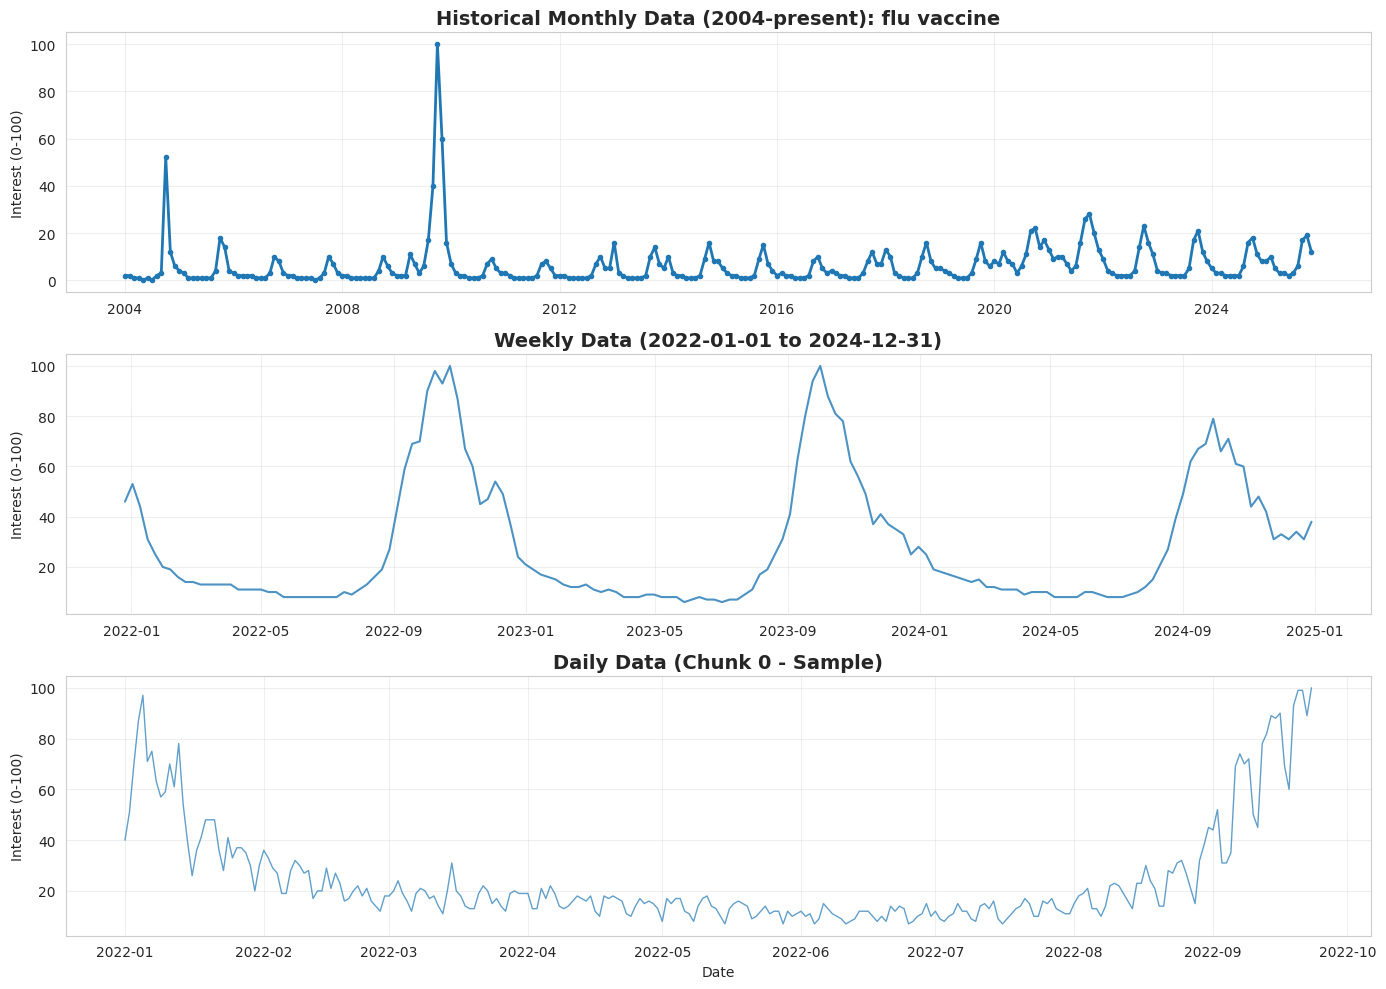

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Plot historical monthly data
axes[0].plot(historical_monthly_data['date'], historical_monthly_data['value'], marker='o', linewidth=2, markersize=3)
axes[0].set_title(f"Historical Monthly Data (2004-present): {config.search_term}", fontsize=14, fontweight='bold')
axes[0].set_ylabel("Interest (0-100)")
axes[0].grid(True, alpha=0.3)

# Plot weekly data
axes[1].plot(weekly_data['date'], weekly_data['value'], linewidth=1.5, alpha=0.8)
axes[1].set_title(f"Weekly Data ({config.date_range.start} to {config.date_range.end})", fontsize=14, fontweight='bold')
axes[1].set_ylabel("Interest (0-100)")
axes[1].grid(True, alpha=0.3)

# Plot first daily chunk as sample
if daily_chunks:
    sample_chunk = daily_chunks[0]
    axes[2].plot(sample_chunk['date'], sample_chunk['value'], linewidth=1, alpha=0.7)
    axes[2].set_title("Daily Data (Chunk 0 - Sample)", fontsize=14, fontweight='bold')
    axes[2].set_ylabel("Interest (0-100)")
    axes[2].set_xlabel("Date")
    axes[2].grid(True, alpha=0.3)

plt.tight_layout()

# Save plot
if config.output.save_plots:
    plot_path = file_manager.get_report_path(f"stage0_data_overview.{config.output.plot_format}")
    plt.savefig(plot_path, dpi=config.output.plot_dpi, bbox_inches='tight')
    print(f"✓ Plot saved to {plot_path}")

plt.show()

## 11. Rescale Data to Historical Monthly Baseline

**CRITICAL STEP:** Google Trends normalizes data differently based on date range:
- Historical monthly (2004-2025): normalized to all-time peak
- Weekly/daily (2022-2024): normalized to recent peak

This creates a scale mismatch. We rescale weekly and daily data to match the historical monthly scale.

In [23]:
print("\n=== Rescaling Data to Historical Monthly Baseline ===\n")

# CORRECTED RESCALING LOGIC
# Problem: Previous version compared weekly-aggregated-to-monthly (SUM of 4-5 weeks)
# with historical monthly (single normalized score), creating incorrect scale factor.
#
# Solution: Use daily chunks directly, aggregate to monthly using SAME method as
# baseline stitching (SUM), then compare with historical monthly.

# Step 1: Average overlapping daily chunks (same as baseline stitching)
print("Step 1: Averaging overlapping daily chunks...")
all_daily_data = []
for i, chunk in enumerate(daily_chunks):
    if len(chunk) > 0:
        chunk_copy = chunk.copy()
        chunk_copy['date'] = pd.to_datetime(chunk_copy['date'])
        all_daily_data.append(chunk_copy[['date', 'value']])

combined_daily = pd.concat(all_daily_data, ignore_index=True)
daily_averaged = combined_daily.groupby('date', as_index=False)['value'].mean()
daily_averaged = daily_averaged.sort_values('date').reset_index(drop=True)
print(f"  Averaged to {len(daily_averaged)} unique dates")

# Step 2: Aggregate daily to monthly (SAME as baseline stitching: SUM)
print("\nStep 2: Aggregating daily to monthly (using SUM, matching baseline method)...")
daily_averaged['month'] = daily_averaged['date'].dt.to_period('M')
daily_monthly = daily_averaged.groupby('month')['value'].sum().reset_index()
print(f"  Aggregated to {len(daily_monthly)} months")

# Step 3: Prepare historical monthly for same period
print("\nStep 3: Filtering historical monthly to 2022-2024...")
hist_filtered = historical_monthly_data[
    (pd.to_datetime(historical_monthly_data['date']) >= '2022-01-01') &
    (pd.to_datetime(historical_monthly_data['date']) <= '2024-12-31')
].copy()
hist_filtered['month'] = pd.to_datetime(hist_filtered['date']).dt.to_period('M')

# Step 4: Merge and calculate scale factor
print("\nStep 4: Calculating scale factor...")
merged = pd.merge(
    hist_filtered[['month', 'value']],
    daily_monthly[['month', 'value']],
    on='month',
    suffixes=('_hist', '_daily')
)

# Calculate per-month scale factors, then take mean
merged['scale_factor'] = merged['value_hist'] / merged['value_daily']
scale_factor = merged['scale_factor'].mean()

print(f"\nScale Factor Analysis:")
print(f"  Historical monthly mean: {merged['value_hist'].mean():.2f}")
print(f"  Daily-aggregated monthly mean: {merged['value_daily'].mean():.2f}")
print(f"  Calculated scale factor: {scale_factor:.4f}")
print(f"  Per-month factors: min={merged['scale_factor'].min():.3f}, max={merged['scale_factor'].max():.3f}")

# Step 5: Apply scaling to weekly data
print(f"\nStep 5: Applying scale factor {scale_factor:.4f} to weekly data...")
weekly_data_original = weekly_data.copy()  # Backup
weekly_data['value'] = weekly_data['value'] * scale_factor
print(f"  ✓ Scaled weekly data")
print(f"    Before: range {weekly_data_original['value'].min():.1f} to {weekly_data_original['value'].max():.1f}")
print(f"    After:  range {weekly_data['value'].min():.1f} to {weekly_data['value'].max():.1f}")

# Step 6: Apply scaling to all daily chunks
print(f"\nStep 6: Applying scale factor to daily chunks...")
for i, chunk in enumerate(daily_chunks):
    if len(chunk) > 0:
        chunk['value'] = chunk['value'] * scale_factor
print(f"  ✓ Scaled {len([c for c in daily_chunks if len(c) > 0])} chunks")

# Step 7: Verification - simulate baseline alpha calculation
print("\nStep 7: Verification (simulating baseline alpha calculation)...")
daily_scaled = []
for chunk in daily_chunks:
    if len(chunk) > 0:
        chunk_copy = chunk.copy()
        chunk_copy['date'] = pd.to_datetime(chunk_copy['date'])
        daily_scaled.append(chunk_copy[['date', 'value']])

combined_scaled = pd.concat(daily_scaled, ignore_index=True)
daily_scaled_avg = combined_scaled.groupby('date', as_index=False)['value'].mean()
daily_scaled_avg['month'] = daily_scaled_avg['date'].dt.to_period('M')
daily_scaled_monthly = daily_scaled_avg.groupby('month')['value'].sum().reset_index()

# Calculate alpha (what baseline stitching will compute)
verification = pd.merge(
    hist_filtered[['month', 'value']],
    daily_scaled_monthly[['month', 'value']],
    on='month',
    suffixes=('_truth', '_raw')
)
verification['alpha'] = verification['value_truth'] / verification['value_raw']

print(f"  Expected alpha statistics after rescaling:")
print(f"    Mean: {verification['alpha'].mean():.3f} (target: ~1.0)")
print(f"    Std:  {verification['alpha'].std():.3f}")
print(f"    Min:  {verification['alpha'].min():.3f}")
print(f"    Max:  {verification['alpha'].max():.3f}")

if 0.8 <= verification['alpha'].mean() <= 1.2:
    print(f"  ✅ Alpha mean is close to 1.0 - rescaling successful!")
else:
    print(f"  ⚠️  Alpha mean is {verification['alpha'].mean():.3f}, not close to 1.0")

# Step 8: Save rescaled data
print(f"\nStep 8: Saving rescaled data...")
weekly_data.to_parquet(weekly_path, index=False)
for i, chunk in enumerate(daily_chunks):
    if len(chunk) > 0:
        chunk_path = file_manager.get_daily_chunk_path(i)
        chunk.to_parquet(chunk_path, index=False)
print("  ✓ Saved rescaled weekly and daily data")

print("\n" + "=" * 60)
print("RESCALING COMPLETE")
print("=" * 60)
print(f"\nNext: Run notebook 02 to verify alpha ≈ 1.0 in actual stitching")


=== Rescaling Data to Historical Monthly Baseline ===

Step 1: Averaging overlapping daily chunks...
  Averaged to 1096 unique dates

Step 2: Aggregating daily to monthly (using SUM, matching baseline method)...
  Aggregated to 36 months

Step 3: Filtering historical monthly to 2022-2024...

Step 4: Calculating scale factor...

Scale Factor Analysis:
  Historical monthly mean: 6.97
  Daily-aggregated monthly mean: 48.43
  Calculated scale factor: 0.1407
  Per-month factors: min=0.075, max=0.184

Step 5: Applying scale factor 0.1407 to weekly data...
  ✓ Scaled weekly data
    Before: range 0.3 to 5.7
    After:  range 0.0 to 0.8

Step 6: Applying scale factor to daily chunks...
  ✓ Scaled 6 chunks

Step 7: Verification (simulating baseline alpha calculation)...
  Expected alpha statistics after rescaling:
    Mean: 1.000 (target: ~1.0)
    Std:  0.214
    Min:  0.536
    Max:  1.309
  ✅ Alpha mean is close to 1.0 - rescaling successful!

Step 8: Saving rescaled data...
  ✓ Saved resca

## Summary

**Phase 1 Complete!** ✓

All data has been fetched and validated. Review the audit report above:
- Check for any errors or warnings
- Verify zero patterns align with expectations
- Confirm chunk overlaps are correct

**Data Collected:**
1. **Historical Monthly** (2004-present) - Long-term context
2. **Weekly** (date range) - Primary ground truth for validation
3. **Daily Chunks** - Data to be stitched

**Next Steps:**
- If validation passed: Proceed to Phase 2 (Stitching Methods)
- If issues found: Review configuration and re-run collection

**Phase 2 Notebooks:**
- `02_baseline.ipynb` - Simple baseline stitching
- `03_hierarchical.ipynb` - Hierarchical optimization (recommended)
- `04_hierarchical_dow.ipynb` - With day-of-week correction